# Interacting with model services

We've seen how to deploy machine learning pipelines into production with `s2i` and now we'll see how we can use these services to make predictions.

First, make sure that the model service you built with source-to-image is running.  Your next step, which is **absolutely necessary**, is to change the `DEFAULT_BASE_URL` in the first code cell.  If you're running this notebook in OpenShift, you'll want to change `pipeline` to the internal service name, or `pipeline:8080` to the external route hostname (if you've set one).  (If you're running this notebook locally and have built and are running the pipeline as a container image, you can probably use `localhost:8080`.)

You can get the internal service name from the OpenShift web console; in the screenshot below, the service name is `pipeline.myproject.svc`.

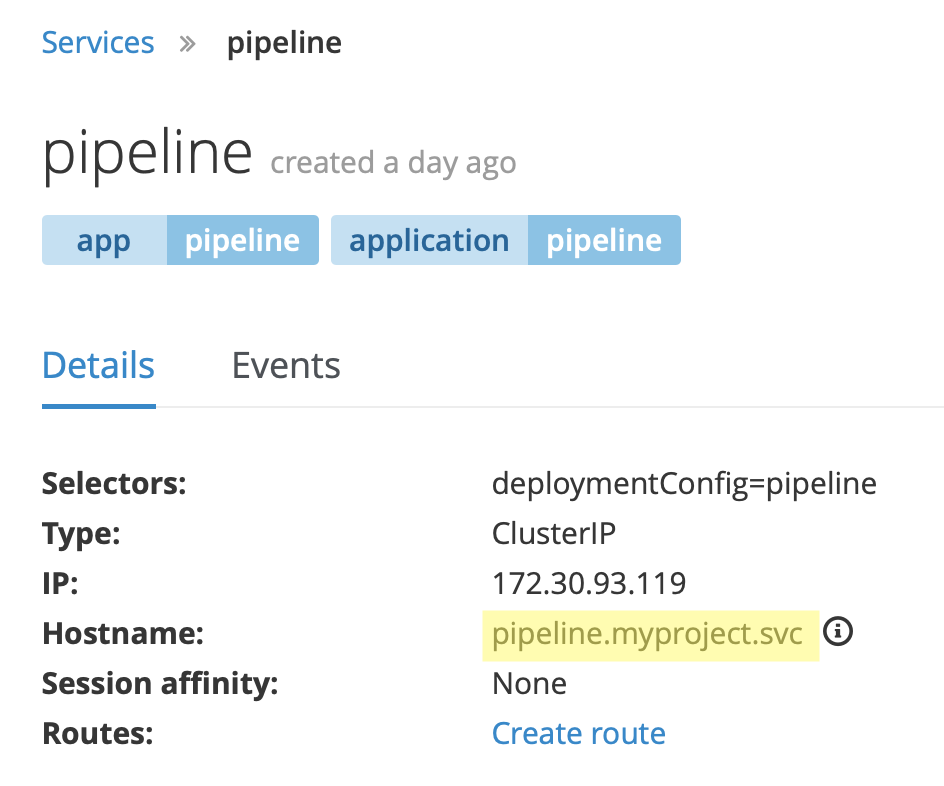

In [ ]:
DEFAULT_BASE_URL = "http://pipeline:8080/%s"

We'll use the `requests` library to interact with the REST service that our `s2i` builder created.  Although we're running this in a notebook, you can certainly imagine how you'd interact with a similar service from an application using your favorite REST client.

In [ ]:
import requests
from urllib.parse import urlencode
import json

def score_text(text, url = None):
    url = (url or (DEFAULT_BASE_URL % "predict")) 
    if type(text) == str:
        text = [text]
    payload = urlencode({"json_args" : json.dumps(text)})
    headers = {'content-type': 'application/x-www-form-urlencoded'}
    response = requests.request("POST", url, data=payload, headers=headers)
    return json.loads(response.text)

def get_metrics(url = None):
    def parse_one_metric(line):
        ll = line.rsplit(' ', 1)
        return (ll[0], float(ll[1]))
    
    url = (url or (DEFAULT_BASE_URL % "metrics")) 
    response = requests.request("POST", url)
    return dict([parse_one_metric(line) for line in response.text.split('\n') if len(line) > 0 and line[0] != '#'])

The `score_text` function we just defined will let us pass in a single document (as a string) or a set of documents (as a list of strings).  Let's try it with some very basic "documents."

In [ ]:
score_text(["dog food",  "It is a truth universally acknowledged"])

Let's try our service with some real documents:

In [ ]:
import pandas as pd
data = pd.read_parquet("data/training.parquet")

In [ ]:
sample = data.sample(200)
sample["predictions"] = score_text(sample["text"].values.tolist())
sample

Running our models as services gives us an interesting opportunity to detect data drift by publishing the distribution of our predictions as metrics.  If the distribution of predictions shifts over time, we can use that as an indication that the distribution of the data we're evaluating has shifted as well, and that we should re-train our model.  
In this example, our pipeline service publishes metrics related to the predictions made by the model (keys beginning with `pipeline_predictions_`) as well as metrics related to the computational performance of our pipeline service (keys beginning with `pipeline_processing_seconds_`).

In [ ]:
get_metrics()

Since our service publishes Prometheus metrics, we can define alerting rules or visualize how our metric values change over time.

In [ ]:
def experiment(data, size, **kwargs):
    for k, v in kwargs.items():
        sample = data[data.label == k].sample(int(size * v))
        score_text(sample["text"].values.tolist())

In [ ]:
experiment(data, 20000, legitimate=.05, spam=.95)
experiment(data, 20000, legitimate=.05, spam=.95)
experiment(data, 20000, legitimate=.05, spam=.95)

In [ ]:
experiment(data, 20000, legitimate=.25, spam=.75)

In [ ]:
experiment(data, 20000, legitimate=1)

# Exercises

1.  What would a REST API for serving multiple versions of multiple pipelines look like?  (Hint:  consider the verbs and nouns involved.)
1.  While we don't have a monitoring stack enabled for this workshop, you can [certainly install and configure one in your own OpenShift cluster](https://docs.openshift.com/container-platform/3.11/install_config/prometheus_cluster_monitoring.html).  What sort of alerting rules might you install to identify data drift in this application?
1.  &starf; What else would you need to change about the simple pipeline service we used in this project in order to use it in production?  (Hint:  to start, consider security, resilience, high-availability, and load-balancing.)
1.  In some environments, being able to _explain_ predictions is important for regulatory or application-specific reasons.  How might you design a pipeline s2i builder that would make it possible to reproduce results from data all the way through model hyperparameter settings?
1.  &starf; Consider how you'd design a ML pipeline service for extremely low-latency environments like transaction processing (in which the round-trip cost of an RPC call might be totally unacceptable).